In [15]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import sklearn 
import tensorflow
import matplotlib 
import dni
import seaborn
import numpy
import pandas
import os
import json

print('torch v:', torch.__version__)
print('torchvision v:', torchvision.__version__)
print('sklearn v:', sklearn.__version__)
print('tensorflow v:', tensorflow.__version__)
print('matplotlib v:', matplotlib.__version__)
print('seaborn v:', seaborn.__version__)
print('numpy v:', numpy.__version__)
print('pandas v:', pandas.__version__)
print('json v:', json.__version__)


torch v: 1.8.0
torchvision v: 0.9.0
sklearn v: 0.24.1
tensorflow v: 2.3.0
matplotlib v: 3.3.4
seaborn v: 0.11.1
numpy v: 1.19.2
pandas v: 1.2.3
json v: 2.0.9


In [20]:
n_epochs = 10000
log_interval = 20

#set random seed
random_seed = 43
torch.manual_seed(random_seed)

#set torch device
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

In [21]:
from dataloader import get_dataloaders

batch_size_train = 256 #specified in the paper
'''
downsample mnist so we can run longer.
set batch sizes = total dataset sizes so we don't need to modify test loop for f1/prec/recall 

'''
train_loader, test_loader = get_dataloaders(5000, 1000, batch_size_train)

### Running SG vs BP

In [4]:
from models import (Four_Layer, Eight_Layer, VGG16_custom, Four_Layer_SG, Eight_Layer_SG, VGG16_SG)
import numpy as np
from train import train,train_sg,test 
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

# train_counter = []
# test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]
history = {}

model_dict = {
    #4-layer convnets
#     'Four_Layer_SG': Four_Layer_SG,
#     'Four_layer': Four_Layer,
#     #8-layer convnets
    'Eight_Layer_SG': Net,
#     'Eight_Layer': Eight_Layer,
    #VGG Models
    'VGG16_SG': VGG16_SG,
#     'VGG16': VGG16_custom,   
}

from time import time

with open('data.json', 'r') as fp:
    data = json.load(fp)
    
for key in model_dict.keys():
    model = model_dict[key]()
    stats = []
    test(model,test_loader)
    print(key, '\n')
    for epoch in tqdm(range(1, n_epochs + 1), leave=False):
        start_time = time()
        
        if 'SG' not in key:
            train(model, epoch, train_loader, log_interval, verbose=False)
        else:
            train_sg(model, epoch, train_loader, log_interval, verbose=False)
            
        end_time = time()
        time_taken = end_time - start_time
        
        metrics = test(model, test_loader)
        metrics.append(time_taken)
            
        stats.append(metrics)
        
    data[key] = stats
    #clear gpu memory
    torch.cuda.empty_cache()

import json
with open('data.json', 'w') as fp:
    json.dump(history, fp)



ImportError: cannot import name 'Net' from 'models' (C:\Users\jdine\Documents\UVA\UVA_Spring2021\Cloud Computing\synthetic_grads\models.py)

In [22]:
'''
history holds:
model key : (acc, precision, recall, f1, support), training time for epoch
computed using weighted average

'''
with open('data.json', 'r') as fp:
    data = json.load(fp)
    


In [50]:
print('PERFORMANCE METRICS ')
for key in data.keys():
    print(key)
    print('acc', max([i[0][0] for i in data[key]]))
    print('prec', max([i[0][1] for i in data[key]]))
    print('recall', max([i[0][2] for i in data[key]]))
    print('f1', max([i[0][3] for i in data['Four_Layer_SG']]))
    print('\n')



PERFORMANCE METRICS 
Four_Layer_SG
acc 95.5
prec 0.9559224137931034
recall 0.955
f1 0.9549426025113246


Four_layer
acc 97.5
prec 0.9755877435613745
recall 0.975
f1 0.9549426025113246


Eight_Layer_SG
acc 92.0
prec 0.925986364682017
recall 0.92
f1 0.9549426025113246


Eight_Layer
acc 98.0
prec 0.9810427807486631
recall 0.98
f1 0.9549426025113246


VGG16_SG
acc 93.0
prec 0.9394805194805196
recall 0.93
f1 0.9549426025113246


VGG16
acc 99.5
prec 0.9952941176470589
recall 0.995
f1 0.9549426025113246




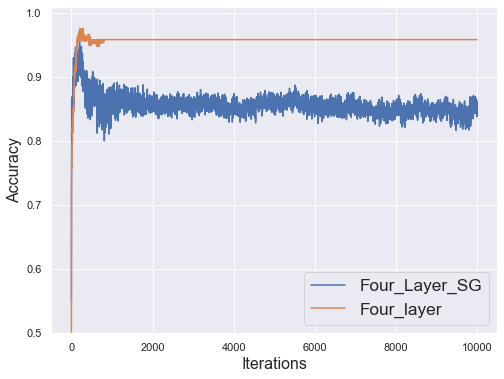

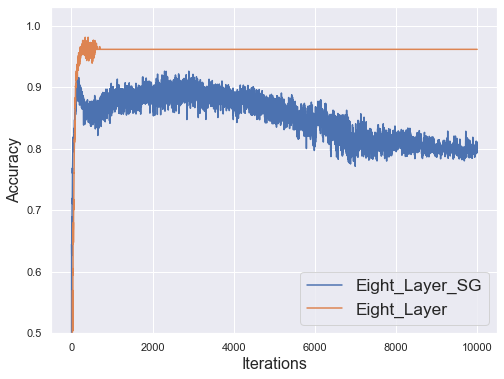

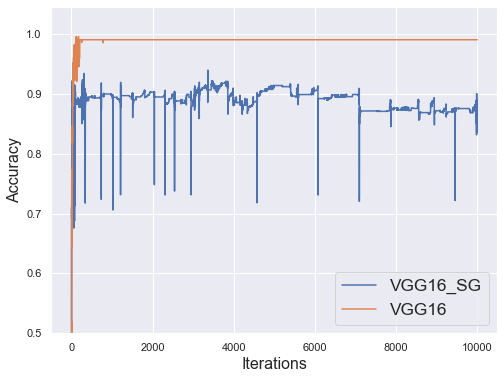

In [130]:
plot = {}
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(8,6)})
for key in data.keys():
    plot[key] = [i[0][1] for i in data[key]]
# #     sns.set(rc={'figure.figsize':(11.7,8.27)})
#     df = pd.DataFrame(plot).plot()
#     plt.ylim(0.5)
#     plt.xlabel('Iterations', fontsize = 16)
#     plt.ylabel('Accuracy', fontsize = 16)
        
df = pd.DataFrame(plot)
four = df.iloc[:, [0,1]]
eight = df.iloc[:, [2,3]]
vgg = df.iloc[:, [4,5]]

for i in [four, eight, vgg]:
    i.plot()
    plt.ylim(0.5)
    plt.xlabel('Iterations', fontsize = 16)
    plt.ylabel('Accuracy', fontsize = 16)
    plt.legend(fontsize='x-large', title_fontsize='40')

In [136]:
for key in data.keys():
    plot[key] = [i[0][1] for i in data[key]]
    df = pd.DataFrame(plot)
df.describe()

,Four_Layer_SG,Four_layer,Eight_Layer_SG,Eight_Layer,VGG16_SG,VGG16
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.856188,0.956892,0.849818,0.957371,0.889399,0.988246
std,0.015459,0.014776,0.040818,0.045770,0.019505,0.033471
min,0.550803,0.309685,0.018053,0.002500,0.213722,0.006400
25%,0.847643,0.958209,0.812534,0.961414,0.875513,0.990294
50%,0.854910,0.958209,0.858067,0.961414,0.893149,0.990294
75%,0.862178,0.958209,0.883117,0.961414,0.898736,0.990294
max,0.955922,0.975588,0.925986,0.981043,0.939481,0.995294


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.lineplot(x = range(EPOCHS), y = logs['four_layer'].history['val_accuracy'], label = '4layer')
sns.lineplot(x = range(EPOCHS), y = logs['eight_layer'].history['val_accuracy'], label = '8layer')
# sns.lineplot(x = range(EPOCHS), y = logs['vgg16'].history['val_accuracy'], label = 'vgg16')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Epoch vs Vali Accuracy - Backprop')
plt.legend()
plt.show()
